# Load and clean the raw data

In [645]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
import datetime
import string
import network_creation_functions as ncf
from importlib import reload

## Read all the data

In [646]:
src = '../../data/raw'

In [647]:
! ls ../../data/raw

course_dates.csv	exam_dates.csv	      rooms.csv
course_enrollment.csv	exam_enrollment.csv   students.csv
courses.csv		exam_supervision.csv  study_labels.csv
course_supervision.csv	lecturers.csv


In [648]:
study_map = ncf.study_map # mapping of studies to degree levels

In [649]:
# List of students with enrolled studies. A student can have more than one study,
# which will show up as separate entries (row) for the same student_id. Each
# study also has a term number, i.e. the number of semesters the student has
# been enrolled in the given study.
students = pd.read_csv(join(src, 'students.csv'))

# Mapping of lecturers to organisations (institute, faculty). A lecturer can
# be associated with more than one organisation.
lecturers = pd.read_csv(join(src, 'lecturers.csv'))

# List of lectures with information about their type, their name, their module
# (this is only relevant for how studies are composed at TU Graz) and the 
# organisational unit (institute, faculty) which is responsible for the lecture.
courses = pd.read_csv(join(src, 'courses.csv'))

# List of enrolled students for courses in the WiSe 2019/20. A courses
# can have several groups (for example for tutorial parts). The group enrollment
# is also listed for every student. It is not completely unique
# as there are a number of overlapping groups (for example same time, 
# different rooms). These are disambiguated at a later point in the data
# cleaning process. The data also includes the identifier of the study through 
# which the student enrolled in a given lecture. 
course_enrollment = pd.read_csv(join(src, 'course_enrollment.csv'))

# List of enrolled students for exams in the WiSe 2019/20.
exam_enrollment = pd.read_csv(join(src, 'exam_enrollment.csv'))

# List of lecturers which are responsible for lectures and groups within
# lectures. Similar to the course enrollment table, the group_id is 
# disambiguated later in the data cleaning process
course_supervision = pd.read_csv(join(src, 'course_supervision.csv'))

# List of lecturers which are responsible for exams. Similar to the course 
# enrollment table, the exam_id is disambiguated later in the data cleaning 
# process
exam_supervision = pd.read_csv(join(src, 'exam_supervision.csv'))

# Courses (start time, end time, room) for every course and group in WiSe 
# 2019/20
course_dates = pd.read_csv(join(src, 'course_dates.csv'), 
                           parse_dates=["date", "start_time", "end_time"])

# Exams (start time, end time, room) for every exam in WiSe 2019/20
exam_dates = pd.read_csv(join(src, 'exam_dates.csv'), 
                           parse_dates=["date"])

# List of rooms and information about them (number of seats, square meters).
# TU Graz has three campuses: Alte Technik, Neue Technik and Inffeldgasse. The
# mapping of every room to a campus is also stored.
# Information for rooms outside TU Graz premises was missing. Jana Lasser 
# manually searched for and filled in room information for rooms at Uni Graz 
# and added the information to the file /data/raw/Räume.csv. The updated file 
# is stored in /data/cleaned/Räume_cleaned.csv. These rooms are excluded from
# the further analysis anyways though.
rooms = pd.read_csv(join(src, 'rooms.csv'))

## Data cleaning

| data | cleaning | checks |
| ---- | -------- | ------ |
| course dates | dropped: dates outside normal hours, dates longer than 13 hours | no dates outside the semester |
| exam dates | dropped: dates outside normal hours, dates without a start time, dates longer than 13 hours| no dates outside the semester, all exams have a supervising lecturer |
| course enrollment | dropped: enrollments without dates |
| exam enrollment | dropped: enrollments without dates |
| courses | dropped: courses without enrollment |
| students | dropped: students without enrollments in courses or exams |
| course supervision | dropped: lecturers who don't supervise a course or exam |
| exam supervision | dropped: lecturers who don't supervise a course or exam |
| lecturers | dropped: organisations without active lecturers |
| rooms | dropped: rooms without courses or exams |





### Ensure all course & exam dates occur inside the semester

In [650]:
# date of the semester start
semester_start = pd.to_datetime(ncf.semester_start)
# date of the semester end
semester_end = pd.to_datetime(ncf.semester_end)

# Make sure all events take place within the time specified by the semester
# start (2019-10-01) and semester end (2020-02-28).
assert len(course_dates) == len(course_dates[course_dates['date'] >= semester_start])
assert len(course_dates) == len(course_dates[course_dates['date'] <= semester_end])

# Make sure all events take place within the time specified by the semester
# start (2019-10-01) and semester end (2020-02-28).
assert len(exam_dates) == len(exam_dates[exam_dates['date'] >= semester_start])
assert len(exam_dates) == len(exam_dates[exam_dates['date'] <= semester_end])

### Drop course & exam dates that occured outside normal lecture hours

In [651]:
# convert the start and end datetime to a time and drop all courses
# which occured outside normal lecture hours, i.e. had a start time
# before 7:00 AM, after 8:00 PM or at exactly midnight (not covered
# by either of the two conditions). We assume these courses are either
# erroneous entries or placeholder courses.
course_dates['start_time'] = course_dates['start_time'].dt.time
course_dates['end_time'] = course_dates['end_time'].dt.time
N = len(course_dates)
course_dates = course_dates[course_dates['start_time'] <= datetime.time(20, 0)]
print('dropped {}/{} courses with a start time later than 8:00 PM'\
      .format(N - len(course_dates), N))
N = len(course_dates)
course_dates = course_dates[course_dates['start_time'] >= datetime.time(7, 0)]
print('dropped {}/{} courses with a start time earlier than 7:00 AM'\
      .format(N - len(course_dates), N))
N = len(course_dates)
course_dates = course_dates[course_dates['start_time'] >= datetime.time(0, 0)]
print('dropped {}/{} courses with a start time at 00:00'\
      .format(N - len(course_dates), N))

dropped 31/29147 courses with a start time later than 8:00 PM
dropped 133/29116 courses with a start time earlier than 7:00 AM
dropped 0/28983 courses with a start time at 00:00


In [652]:
N = len(exam_dates)
exam_dates = exam_dates.dropna(subset=["start_time"])
print('dropped {}/{} exams without start time'\
      .format(N - len(exam_dates), N))
N = len(exam_dates)
print('{} ({:1.2f}%) exams do not have an end time'\
      .format(N - len(exam_dates["end_time"].dropna()), 
              (N - len(exam_dates["end_time"].dropna())) / N * 100))

print('{} ({:1.2f}%) exams do not have an assigned room'\
      .format(N - len(exam_dates["room_id"].dropna()), 
              (N - len(exam_dates["room_id"].dropna())) / N * 100))

dropped 144/5633 exams without start time
2745 (50.01%) exams do not have an end time
3517 (64.07%) exams do not have an assigned room


### Merge course and exam dates to event dates

In [653]:
exam_dates = exam_dates.rename(columns={"exam_id":"group_id"})

In [654]:
def get_time(timestring):
    if timestring != timestring:
        return np.nan
    else:
        hour, minute = timestring.split(':')
        return datetime.time(int(hour), int(minute))

In [655]:
# convert the start and end time string to a time object
exam_dates['start_time'] = exam_dates['start_time']\
    .apply(get_time)
exam_dates['end_time'] = exam_dates['end_time']\
    .apply(get_time)

In [656]:
event_dates = pd.concat([course_dates, exam_dates])
event_dates = event_dates.reset_index(drop=True)
del course_dates
del exam_dates

### Calculate event durations and drop events that take too long

In [657]:
# Calculate the duration of events and drop all events that have a duration
# of more than 13 hours. We assume these events are either erroneous entries 
# or placeholder events.
event_dates['duration'] = event_dates.apply(ncf.calculate_duration, axis=1)
duration_threshold = 13 * 60

def nan_leq(duration):
    '''Returns true in the duration is <= duration_threshold or NaN'''
    if duration != duration:
        return True
    elif duration <= duration_threshold:
        return True
    else:
        return False
    
N = len(event_dates) 
event_dates = event_dates[event_dates['duration'].apply(nan_leq)]
print("dropped {}/{} events that were longer than {} minutes"\
      .format(N - len(event_dates), N, duration_threshold))

dropped 2/34472 events that were longer than 780 minutes


### Merge course and exam enrollments

In [658]:
exam_enrollment = exam_enrollment.rename(columns={"exam_id":"group_id"})
enrollment = pd.concat([course_enrollment, exam_enrollment])
enrollment = enrollment.reset_index(drop=True)
del course_enrollment
del exam_enrollment

### Drop course and exam enrollments without dates

In [659]:
enrollment.head(2)

,student_id,study_id,course_id,group_id
0,vRQOAh9YNITSSLRKCjsaH6CblbmGBdq,UF 033 245,225442,263409
1,8CS8qLNtrgXgcNWU6M3p0Avt1YOWrFm,UF 033 273,226073,254793


In [660]:
course_IDs = set(event_dates["course_id"])
#exam_IDs = set(exam_dates["exam_id"])

N = len(enrollment["course_id"].unique())
enrollment = enrollment[enrollment["course_id"].isin(course_IDs)]
print('dropped {}/{} enrollments without dates'\
      .format(N - len(enrollment["course_id"].unique()), N))

dropped 84/3080 enrollments without dates


### Drop event dates without enrollment

In [661]:
# filter out courses and exams without enrollment
course_IDs = set(enrollment["course_id"])

N = len(event_dates["course_id"].unique())
event_dates = event_dates[event_dates["course_id"].isin(course_IDs)]
print('dropped {}/{} dates associated with courses without enrollment'\
      .format(N - len(event_dates["course_id"].unique()), N))

assert len(enrollment["course_id"].unique()) == len(event_dates["course_id"].unique())

# all courses (+ exams) = events that took place and had enrollment
print(f"{len(course_IDs)} courses and exams remaining")

dropped 313/3309 dates associated with courses without enrollment
2996 courses and exams remaining


### Add exams to course table

In [662]:
only_exam_courses = pd.DataFrame({"course_id":event_dates[~event_dates["course_id"]\
                        .isin(courses["course_id"])]["course_id"].unique()})

only_exam_courses["course_name"] = np.nan
only_exam_courses["course_type"] = "EX"
courses = pd.concat([courses, only_exam_courses])
courses = courses.reset_index(drop=True)
del only_exam_courses

### Drop courses without enrollment

In [663]:
N = len(courses)
courses = courses[courses["course_id"].isin(course_IDs)]
print('dropped {}/{} courses without enrollment'\
      .format(N - len(courses["course_id"].unique()), N))

assert len(courses["course_id"].unique()) == len(event_dates["course_id"].unique())
assert len(courses["course_id"].unique()) == len(enrollment["course_id"].unique())
assert len(enrollment["course_id"].unique()) == len(event_dates["course_id"].unique())

dropped 4547/7543 courses without enrollment


### Drop inactive students

In [664]:
# filter out inactive students
active_students = set(enrollment["student_id"].unique())
students = students[students["student_id"].isin(active_students)]
N_students = len(active_students)
print(f"{N_students} students were active in courses or exams in WiSe 2019/20")
N_student_info = len(students["student_id"].unique())
print(f"No term & study information for {N_students - N_student_info} students")

13358 students were active in courses or exams in WiSe 2019/20
No term & study information for 139 students


### Drop course supervision entries without enrollment

In [665]:
# filter out lecturers without courses
N = len(course_supervision["lecturer_id"].unique())
course_supervision = course_supervision[course_supervision["course_id"].isin(course_IDs)]
print('dropped {}/{} course supervisions with no enrollment in supervised course'\
      .format(N - len(course_supervision["lecturer_id"].unique()), N))

dropped 288/1853 course supervisions with no enrollment in supervised course


### Drop exam supervision entries without enrollment

In [666]:
# filter out lecturers without courses
N = len(exam_supervision["lecturer_id"].unique())
exam_supervision = exam_supervision[exam_supervision["course_id"].isin(course_IDs)]
print('dropped {}/{} exam supervisions with no enrollment in supervised exam'\
      .format(N - len(exam_supervision["lecturer_id"].unique()), N))

dropped 1/870 exam supervisions with no enrollment in supervised exam


In [667]:
# make sure all courses with enrollment have a supervisor
supervised_course_IDs = set(course_supervision["course_id"])\
                 .union(set(exam_supervision["course_id"]))
assert len(set(courses["course_id"]).difference(supervised_course_IDs)) == 0

### Merge course and exam supervision

In [668]:
exam_supervision = exam_supervision.rename(columns={"exam_id":"group_id"})
supervision = pd.concat([course_supervision, exam_supervision])
supervision = supervision.reset_index(drop=True)
del course_supervision
del exam_supervision

### Drop lecturers without active supervision

In [669]:
# filter out lecturers without courses
lecturer_IDs = set(supervision["lecturer_id"])
N = len(lecturers["lecturer_id"].unique())
lecturers = lecturers[lecturers["lecturer_id"].isin(lecturer_IDs)]
print('dropped {}/{} lecturers without supervision of course or exam'\
      .format(N - len(lecturers["lecturer_id"].unique()), N))

dropped 3810/5302 lecturers without supervision of course or exam


### Drop rooms without courses or exams

In [670]:
event_dates["room_id"] = event_dates["room_id"].replace({-999999.0:np.nan})
rooms["room_id"] = rooms["room_id"].astype(int)
room_IDs = set(event_dates["room_id"].dropna())

N = len(rooms["room_id"].unique())
rooms = rooms[rooms["room_id"].isin(room_IDs)]
print('dropped {}/{} rooms without courses or exams'\
      .format(N - len(rooms["room_id"].unique()), N))

# make sure there are no duplicate rooms
assert len(rooms) == len(rooms["room_id"].unique())
print(f"{len(rooms)} rooms remaining")

dropped 1892/2288 rooms without courses or exams
396 rooms remaining


## Data enrichment

### Manually add missing studies

In [671]:
# IDs of studies through which students are enrolled in courses and examx, but
# which are not recorded in the student table. 
study_IDs = set(enrollment['study_id'])
diff = set(study_IDs).difference(students["study_id"])
diff

{'PH 198 400 420 01',
 'PH 198 404 426 01',
 'UB 032 331 342',
 'UB 190 406 344',
 'UB 190 406 347',
 'UB 190 406 482',
 'UB 190 445 313',
 'UB 190 445 412',
 'UB 190 456 445',
 'UB 198 411 435 01',
 'UB 198 423 429 01',
 'UB 199 514 520 01',
 'UB 796 600 682',
 'UE 033 273',
 'UF 050 407',
 'UF 066 434',
 'UF 199 505 520 01',
 'UG 033 206',
 'UL 033 289'}

In [672]:
# a number of studies through which students are either enrolled in courses or
# exams are not contained in the student table. Therefore the name of the study
# is missing and we have just the ID. We manually searched for the names of 
# these studies and add them to the student table here. Since we don't know the 
# term numbers for the students in these studies, we set them to NaN. 
missing_studies = enrollment[enrollment['study_id'].isin(diff)]\
    .drop_duplicates(subset=['study_id'])\
    .drop(columns=['course_id', 'group_id'])

# manually searched study names
missing_studies_names = {
    'PH 198 400 420 01':'Lehramtsstudium; UF Bewegung und Sport; UF Mathematik',
    'PH 198 404 426 01':'Lehramtsstudium; UF Chemie; UF Russisch',
    'UB 032 331 342':'Bachelorstudium; Transkulturelle Kommunikation, Deutsch',
    'UB 190 406 344':'Lehramtsstudium; UF Mathematik; UF Englisch',
    'UB 190 406 347':'Lehramtsstudium; UF Mathematik; UF Französisch',
    'UB 190 406 482':'Lehramtsstudium; UF Mathematik; UF Bewegung und Sport',
    'UB 190 445 313':'Lehramtsstudium; UF Biologie und Umweltkunde; UF Geschichte, Sozialkunde, Polit.Bildg.',
    'UB 190 445 412':'Lehramtsstudium; UF Biologie und Umweltkunde; UF Physik',
    'UB 190 456 445':'Lehramtsstudium; UF Geographie und Wirtschaftskunde; UF Biologie und Umweltkunde',
    'UB 198 411 435 01':'Lehramtsstudium; UF Geschichte/Sozialkunde/Polit. Bildung; UF Gestaltung: Technik.Textil',
    'UB 198 423 429 01':'Lehramtsstudium; UF Physik; UF Spanisch',
    'UB 199 514 520 01':'Lehramtsstudium; UF Informatik; UF Mathematik',
    'UB 796 600 682':'Doktoratsstudium; Naturwissenschaften a.d. Naturwiss. Fak.; Physics',
    'UE 033 273':'Bachelorstudium; Verfahrenstechnik',
    'UF 050 407':'Erweiterungsstudium; UF Darstellende Geometrie',
    'UF 066 434':'Masterstudium; Advanced Materials Science',
    'UF 199 505 520 01':'Masterstudium; Lehramt Sek (AB) UF Darstellende Geometrie UF Mathematik',
    'UG 033 206':'Bachelorstudium; Angewandte Geowissenschaften',
    'UL 033 289':'Bachelorstudium; Informationstechnik'
}
missing_studies['study_name'] = missing_studies['study_id'].replace(missing_studies_names)
missing_studies['term_number'] = np.nan

# add missing studies to the study df and ensure that all studies of all students
# are now contained in both the students and the studies df
students = pd.concat([students, missing_studies]).reset_index(drop=True)
assert len(study_IDs.difference(set(students['study_id']))) == 0
del missing_studies

### Add the study level

In [673]:
# the text before the semicolon in the study_name field describes (approximately) 
# the degree and is mapped to a unified pre / post graduate degree scheme that was
# informed by Timotheus Hell
students['study_level'] = students['study_name'].apply(lambda x: x.split(';')[0])
students['study_level'] = students['study_level'].replace(study_map)

students.head(2)

,student_id,study_id,study_name,term_number,study_level
0,IvsbBgC3aMFkfOPdtzoBhgVbAB1nw6O,UB 198 407 417 01,Bachelorstudium Lehramt Sek (AB); UF Englisch;...,7.0,bachelor
1,urKtsWoZBITcE0CeUua5eWUJsQW1GMK,UB 033 662,Bachelorstudium; Chemie,8.0,bachelor


### Manually add information on missing rooms

In [674]:
# rooms for which there is no information in the room table
set(room_IDs).difference(rooms["room_id"])

{18955.0, 19956.0, 22368.0, 22408.0, 29134.0, 29135.0}

In [675]:
# found in KFU room search system
room1 = {"room_id":18955, "seats":np.nan, "area":159, "campus":"KFU",
 "address":"Universitätsplatz 1", "postal_code":8010, "city":"Graz"}

# found in KFU room search system
room2 = {"room_id":19956, "seats":130, "area":147, "campus":"KFU",
 "address":"Heinrichstraße 36", "postal_code":8010, "city":"Graz"}

# found in KFU room search system
room3 = {"room_id":22368, "seats":105, "area":62, "campus":"KFU",
 "address":"Universitätsplatz 5", "postal_code":8010, "city":"Graz"}

# somehwere in the institute for Electronics
room4 = {"room_id":22408, "seats":np.nan, "area":np.nan, "campus":"Inffeldgasse",
 "address":"Heinrichstraße 36", "postal_code":8010, "city":"Graz"}

# found and measured by hand in TU Graz online room search system
room5 = {"room_id":29134, "seats":np.nan, "area":51, "campus":"Alte Technik",
 "address":"Technikerstraße 4", "postal_code":8010, "city":"Graz"}

# not found in TU or KFU
room6 = {"room_id":29135, "seats":np.nan, "area":np.nan, "campus":np.nan,
 "address":np.nan, "postal_code":8010, "city":"Graz"}

rooms = rooms.append([room1, room2, room3, room4, room5, room6], ignore_index=True)

assert len(room_IDs.difference(set(rooms["room_id"]))) == 0

## Controversial stuff

### Assign study labels (TU & NAWI)

In [547]:
# TU Graz offers a wide variety of studies. Some of them in cooperation with
# other local universities, such as Uni Graz, the university of arts and
# teaching studies (organised Austria-wide). The vast majority of these
# collaborative studies are organised under the umbrella of "NaWi Graz"
# (NaturWissenschaften Graz), in cooperation with Uni Graz. 

# Students who are enrolled in one of these collaboratively organised studies
# have a high chance of having the majority of their classes at the premises 
# of other universities. We therefore assign the studies to a total of 6
# labels, indicating which university they belong to. This will later enable
# us to filter by study and exclude students which are not enrolled in 
# native TU Graz studies.

# study labels (supplied by Timotheus Hell):
# "t": TU Graz study
# "n": NaWi Graz study (study with uni Graz)
# "l": teaching study (study with 8 other universities)
# "k": study with university of arts
# "w": further training courses
# "a": other university
study_labels = pd.read_csv(join('../../data/raw', 'study_labels.csv'))
label_map = {row['study_id']:row['study_label'] for i, row in \
            study_labels.iterrows()}
students['study_label'] = students['study_id'].replace(label_map)

In [551]:
known_labels = set(label_map.keys())
unknown_labels = set(students["study_id"]).difference(known_labels)

In [558]:
pd.DataFrame({"unknown_labels":list(unknown_labels)}).to_csv("unknown_labels.csv", index=False)

### Student enrolled studies from long to wide format

In [459]:
N_students = len(students["student_id"].unique())
N_multiple_studies = (students["student_id"].value_counts() > 1).sum()
print(f"{N_multiple_studies}/{N_students} students have more than one study")

1773/13220 students have more than one study


In [460]:
max_studies = students["student_id"].value_counts().max()

new_students = pd.DataFrame({"student_id":students["student_id"].unique()})
for study in range(1, max_studies + 1):
    new_students[f"study_id_{study}"] = np.nan
    new_students[f"study_name_{study}"] = np.nan
new_students = new_students.set_index("student_id")

for student_id in new_students.index:
    student_df = students[students["student_id"] == student_id]
    if len(student_df) == 1:
        new_students.loc[student_id, "study_id_1"] = \
            student_df["study_id"].values[0]
        new_students.loc[student_id, "study_name_1"] = \
            student_df["study_name"].values[0]
    else:
        j = 1
        for index, row in student_df.iterrows():
            new_students.loc[student_id, f"study_id_{j}"] = \
                row["study_id"]
            new_students.loc[student_id, f"study_name_{j}"] = \
                row["study_name"]
            j += 1
            
students = new_students.reset_index()

# make sure that there are no students with more than one study anymore
assert len(students) == len(students["student_id"].unique())

### Lecturer affiliation from long to wide format

In [429]:
N_lectureres = len(lecturers["lecturer_id"].unique())
N_double_affiliations = (lecturers["lecturer_id"].value_counts() > 1).sum()
print(f"{N_double_affiliations}/{N_lectureres} lecturers have more than one affiliation")

168/1492 lecturers have more than one affiliation


In [430]:
max_affiliations = lecturers["lecturer_id"].value_counts().max()

new_lecturers = pd.DataFrame({"lecturer_id":lecturers["lecturer_id"].unique()})
for affiliation in range(1, max_affiliations + 1):
    new_lecturers[f"organisation_id_{affiliation}"] = np.nan
    new_lecturers[f"organisation_name_{affiliation}"] = np.nan
new_lecturers = new_lecturers.set_index("lecturer_id")

for lecturer_id in new_lecturers.index:
    lecturer_df = lecturers[lecturers["lecturer_id"] == lecturer_id]
    if len(lecturer_df) == 1:
        new_lecturers.loc[lecturer_id, "organisation_name_1"] = \
            lecturer_df["organisation_name"].values[0]
        new_lecturers.loc[lecturer_id, "organisation_id_1"] = \
            int(lecturer_df["organisation_id"].values[0])
    else:
        j = 1
        for index, row in lecturer_df.iterrows():
            #print(j)
            new_lecturers.loc[lecturer_id, f"organisation_id_{j}"] = \
                int(row["organisation_id"])
            new_lecturers.loc[lecturer_id, f"organisation_name_{j}"] = \
                row["organisation_name"]
            j += 1
            
lecturers = new_lecturers.reset_index()

# make sure that there are no lecturers with more than one affiliation anymore
assert len(lecturers) == len(lecturers["lecturer_id"].unique())

## Describe data

In [68]:
study_level_df = studies[\
        studies["study_id"].isin(students["study_id"].unique())]\
        [["study_id", "study_level"]]\
        .drop_duplicates()

study_level_df.groupby("study_level").agg("count")

,study_id
study_level,
PhD,43
bachelor,164
bachelor & master,32
master,89
non-degree programme,8


In [70]:
study_label_df = studies[\
        studies["study_id"].isin(students["study_id"].unique())]\
        [["study_id", "study_label"]]\
        .drop_duplicates()

study_label_df.groupby("study_label").agg("count")

,study_id
study_label,
a,64
k,3
l,157
n,47
t,60
w,5


In [78]:
student_study_label_df = \
    students[["student_id", "study_label"]]\
    .drop_duplicates()\
    .groupby("study_label").count()
student_study_label_df

,student_id
study_label,
a,395
k,325
l,479
n,5471
t,10608
w,133


In [59]:
# we only keep students who are enrolled in either a native TU or a NaWi
# study. These students are the vast majority, only 387 students are 
# dropped because they are enrolled in another study.
N = len(students['student_id'].unique())
students = students[students['study_label'].isin(['t', 'n'])]
print('dropped {}/{} students that do not have a TU or NaWi Graz study'\
    .format(N - len(students['student_id'].unique()), N))

# remove entries in the studies-df that correspond to students or studies
# which are not active in WiSe 2019/20 or not enrolled in native TU Graz 
# or NaWi studies
studies = studies[studies['study_label'].isin(['t', 'n'])]
studies = studies[studies['student_id'].isin(students['student_id'].unique())]

dropped 387/12710 students that do not have a TU or NaWi Graz study


### Determine a student's main study

**Note**: this is performed at the graph creation step when student nodes are added in `network_creation_functions.add_students()`.

In [16]:
'''
# count the number of lectures a student visits from each distinct study
lecture_counts = students[['student_id', 'study_id', 'lecture_id']]\
    .groupby(['student_id', 'study_id'])\
    .count()\
    .rename(columns={'lecture_id':'lecture_count'}).copy()
'''

"\n# count the number of lectures a student visits from each distinct study\nlecture_counts = students[['student_id', 'study_id', 'lecture_id']]    .groupby(['student_id', 'study_id'])    .count()    .rename(columns={'lecture_id':'lecture_count'}).copy()\n"

In [17]:
'''
students = students.set_index('student_id')
students['main_study'] = np.nan

for student_id in lecture_counts.index.get_level_values(0):
    student_data = lecture_counts.loc[student_id]
    # student has lectures from more than one study?
    if len(student_data) > 1:
        # pick the study with the most lectures as the main study
        max_lectures = lecture_counts.loc[student_id]['lecture_count'].max()
        student_data = student_data[student_data['lecture_count'] == max_lectures]
        # student has the same amount of lectures from multiple studies?
        if len(student_data) > 1:
            # pick a random study as main study
            student_data = student_data.sample(1, random_state=42)
    
    assert len(student_data) == 1
    students.loc[student_id, 'main_study'] = student_data.index[0]

students = students.reset_index()
assert len(students) == len(students.dropna(subset=['main_study']))
'''

"\nstudents = students.set_index('student_id')\nstudents['main_study'] = np.nan\n\nfor student_id in lecture_counts.index.get_level_values(0):\n    student_data = lecture_counts.loc[student_id]\n    # student has lectures from more than one study?\n    if len(student_data) > 1:\n        # pick the study with the most lectures as the main study\n        max_lectures = lecture_counts.loc[student_id]['lecture_count'].max()\n        student_data = student_data[student_data['lecture_count'] == max_lectures]\n        # student has the same amount of lectures from multiple studies?\n        if len(student_data) > 1:\n            # pick a random study as main study\n            student_data = student_data.sample(1, random_state=42)\n    \n    assert len(student_data) == 1\n    students.loc[student_id, 'main_study'] = student_data.index[0]\n\nstudents = students.reset_index()\nassert len(students) == len(students.dropna(subset=['main_study']))\n"

## Organisations

## Dates & rooms

### Drop rooms and dates that are not on TU Graz premises

In [22]:
# drop all rooms which are not on TU Graz premises
N = len(rooms)
rooms = rooms[rooms['campus'].isin(['Inffeldgasse', 'Alte Technik',
                                    'Neue Technik'])]
print('dropped {}/{} rooms that are not on TU Graz premises'\
      .format(N - len(rooms), N))

# drop all events that ocurred in rooms outside TU Graz premises
N = len(dates)
dates = dates[dates['room_id'].isin(rooms['room_id'].unique())]
print('dropped {}/{} events that occured in rooms outside TU Graz premises'\
      .format(N - len(dates), N))

dropped 72/2288 rooms that are not on TU Graz premises
dropped 640/29147 events that occured in rooms outside TU Graz premises


### Calculate event durations

In [24]:
# Calculate the duration of events and drop all events that have a duration
# of more than 13 hours. We assume these events are either erroneous entries 
# or placeholder events.
dates['duration'] = dates.apply(ncf.calculate_duration, axis=1)
dates = dates[dates['duration'] <= 780]

In [25]:
dates.to_csv('../data/processed/dates_all_students.csv', index=False)

### Drop all events and rooms that are not visited by students

In [26]:
# drop all events that are not visited by students in WiSe 2019/20
N = len(dates)
dates = dates[dates['lecture_id'].isin(students['lecture_id'])]
print('dropped {}/{} events that are not visited by'\
      .format(N - len(dates), N) + \
      ' TU Graz or NaWi students on TU premises during the WiSe 2019/20')

# drop all rooms that are associated with events that are not visited by
# students in WiSe 2019/20
N = len(rooms)
rooms = rooms[rooms['room_id'].isin(dates['room_id'])]
print('dropped {}/{} rooms that are associated with events that are not visited'\
     .format(N - len(rooms), N))

N = len(rooms[rooms['room_id'].isin(dates['room_id'])])
print('{}/{} relevant rooms have no seat information'\
      .format( N -\
              len(rooms[rooms['room_id'].isin(dates['room_id'])]\
                      .dropna(subset=['seats'])), N))

rooms['seats'] = rooms['seats'].astype(int)
rooms.head(3)

dropped 3386/28369 events that are not visited by TU Graz or NaWi students on TU premises during the WiSe 2019/20
dropped 1846/2216 rooms that are associated with events that are not visited
0/370 relevant rooms have no seat information


,room_id,room_code,seats,area,campus
10,5543,HFEG109,92,9,Inffeldgasse
12,1142,NA01158F,49,23,Alte Technik
21,485,PH02112,47,60,Neue Technik


### Visualize event durations

,room_id,date,start_time,end_time,lecture_id,group_id,datetime,duration
0,963,2019-10-01,12:15:00,15:00:00,225453,257599,2019-10-01 12:15:00,165.0
1,2185,2019-10-01,10:00:00,11:30:00,226849,259479,2019-10-01 10:00:00,90.0
2,2661,2019-10-01,08:30:00,10:00:00,226790,259420,2019-10-01 08:30:00,90.0


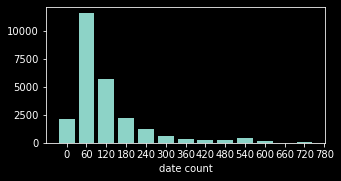

In [27]:
fig, ax = plt.subplots(figsize=(5, 2.5))
ax.hist(dates['duration'], rwidth=0.8, bins=range(0, 800, 60), align='left')
ax.set_xticks(range(0, 800, 60))
ax.set_xlabel('date duration [min]')
ax.set_xlabel('date count')

dates = dates.sort_values(by='date').reset_index(drop=True)
dates.head(3)

In [28]:
# remove lectures that happened outside TU Graz premises
N = len(lectures)
lectures = lectures[lectures['lecture_id'].isin(dates['lecture_id'].unique())]
print('dropped {}/{} lectures that happened outside TU Graz premises or outside the semester'\
      .format(N - len(lectures), N))

dropped 124/1747 lectures that happened outside TU Graz premises or outside the semester


In [29]:
# remove lecturers that teach lectures outside TU Graz premises
N = len(lecturers['lecturer_id'].unique())
lecturers = lecturers[lecturers['lecture_id'].isin(dates['lecture_id'].unique())]
print('dropped {}/{} lecturers that taught lectures that happened outside TU Graz premises or outside the semester'\
      .format(N - len(lecturers['lecturer_id'].unique()), N))

dropped 27/1502 lecturers that taught lectures that happened outside TU Graz premises or outside the semester


In [30]:
# remove student enrollments in lectures that happened outside TU Graz premises
N = len(students)
students = students[students['lecture_id'].isin(dates['lecture_id'].unique())]
print('dropped {}/{} student visits to lectures that happened outside TU Graz premises or outside the semester'\
      .format(N - len(students), N))

dropped 1653/82716 student visits to lectures that happened outside TU Graz premises or outside the semester


### Visualize term and student counts

there are 106 unique TU Graz or NaWi studies
11861 unique TU Graz or NaWi students are registered at TU Graz

number of studies per student
1    10387
2     1360
3      122
4        7
5        3
7        2
6        1
Name: n_studies, dtype: int64

number of students per study
36    904
30    802
32    755
31    748
37    687
29    681
28    643
34    619
42    566
26    529
Name: n_students, dtype: int64
the mean and median term number was 4.98 and 4.0, respectively
the mean and median number of students per study was 126.50 and 49.0, respectively


,student_id,study_id,study_name,term_number,study_level,study_label
10,163041,UF 066 465,Masterstudium; Bauing.wiss.-Konstruktiver Inge...,1.0,master,t
11,207552,UF 033 245,Bachelorstudium; Maschinenbau,1.0,bachelor,t
15,149959,UF 033 282,Bachelorstudium; Wirtschaftsingenieurwesen-Mas...,11.0,bachelor,t


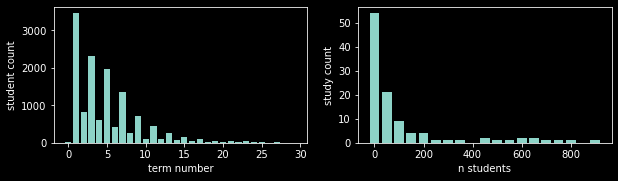

In [31]:
print('there are {} unique TU Graz or NaWi studies'\
      .format(len(students['study_id'].unique())))
print('{} unique TU Graz or NaWi students are registered at TU Graz'\
      .format(len(students['student_id'].unique())))

n_studies = studies[['student_id', 'study_id']]\
    .groupby('student_id')\
    .count()\
    .rename(columns={'study_id':'n_studies'})\
    .reset_index()
print('\nnumber of studies per student')
print(n_studies['n_studies'].value_counts())

n_students = studies[['student_id', 'study_id']]\
    .groupby('study_id')\
    .count()\
    .rename(columns={'student_id':'n_students'})\
    .reset_index()\
    .sort_values(by='n_students', ascending=False)
print('\nnumber of students per study')
print(n_students['n_students'][0:10])

fig, axes = plt.subplots(1, 2, figsize=(10, 2.5))
axes[0].hist(studies['term_number'], rwidth=0.8, bins=range(0, 31, 1), align='left')
axes[0].set_xlabel('term number')
axes[0].set_ylabel('student count')

axes[1].hist(n_students['n_students'], rwidth=0.8, bins=range(0, 1000, 50),
             align='left')
axes[1].set_xlabel('n students')
axes[1].set_ylabel('study count')

print('the mean and median term number was {:1.2f} and {}, respectively'\
      .format(studies['term_number'].mean(), studies['term_number'].median()))

print('the mean and median number of students per study was {:1.2f} and {}, respectively'\
      .format(n_students['n_students'].mean(), n_students['n_students'].median()))


studies.head(3)

## Groups

### Map lecture group IDs to lecture IDs

A lecture group is usually the tutorial that takes place alongside the lecture (especially for the lecture type "VU", lecture + tutorial).

In [32]:
# mapping of lecture group IDs to lecture IDs
groups = students[['lecture_id', 'group_id']].drop_duplicates().copy()
assert len(groups) == len(groups['group_id'].unique())

groups2 = lecturers[['lecture_id', 'group_id']].drop_duplicates().copy()
diff = list(set(groups['group_id']).difference(set(groups2['group_id'])))
print('there are {} groups that have no assigned lecturer'.format(len(diff)))

N = len(groups)
groups = groups[groups['group_id'].isin(dates['group_id'].unique())]
print('dropped {}/{} groups that had no assigned date in the range {} - {}'\
      .format(N - len(groups), N, semester_start, semester_end))

print('there are {} unique groups and {} lectures left'\
      .format(len(groups['group_id'].unique()), 
              len(groups['lecture_id'].unique())))

groups = groups.reset_index(drop=True)

groups.head(3)

there are 27 groups that have no assigned lecturer
dropped 381/2459 groups that had no assigned date in the range 2019-10-01 - 2020-02-28
there are 2078 unique groups and 1526 lectures left


,lecture_id,group_id
0,226073,254793
1,226598,260636
2,221416,258125


### Disambiguate group IDs

In [33]:
letter_list = list(string.ascii_lowercase)
dates['new_group_id'] = np.nan
for date in dates['date'].unique():
    #print(date)
    for group_id in groups['group_id']:
        # dates that happen at the same time for the same group
        group_dates = dates[(dates['group_id'] == group_id) & \
                            (dates['date'] == date)]
        # is there more than one date for the same group id on a given day?
        # do the duplicate dates start at the same time?
        if (len(group_dates) > 1) and \
           (len(group_dates['start_time'].drop_duplicates()) < len(group_dates)):
            
            # de-duplicate group ids stat start at the same time by adding a 
            # letter at the end of the id
            for dt in group_dates['datetime']:
                group_datetimes = group_dates[group_dates['datetime'] == dt]
                assert len(group_datetimes) <= len(letter_list)
                #print('\t{}: entries {}'.format(group_id, len(group_datetimes)))
                
                for index, letter in zip(group_datetimes.index, letter_list):
                    dates.loc[index, 'new_group_id'] = '{}{}'.format(group_id, letter)

In [34]:
splits = dates[['group_id', 'new_group_id']].dropna().drop_duplicates()
print('{} groups had more than one date on the same day and at the same time and were split into {} new groups'\
      .format(len(splits['group_id'].unique()), len(splits)))

116 groups had more than one date on the same day and at the same time and were split into 277 new groups


### Assign new group IDs to students

In [35]:
students['new_group_id'] = np.nan
for group_id in splits['group_id'].unique():
    students_in_group = students[students['group_id']  == group_id]
    new_group_ids = splits[splits['group_id'] == group_id]['new_group_id'].values
    new_group_size = int(len(students_in_group) / len(new_group_ids))
    assert new_group_size >= 1
    
    for i, ID in enumerate(new_group_ids[0:-1]):
        students.loc[students_in_group[\
            i * new_group_size:(i + 1) * new_group_size].index]['new_group_id']\
            = ID
    students.loc[students_in_group[(i + 1) * new_group_size:].index]['new_group_id']\
            = new_group_ids[-1]

### Assign new group IDs to lecturers

In [36]:
lonely_groups = 0
lecturers['new_group_id'] = np.nan
for group_id in splits['group_id'].unique():
    lecturers_in_group = lecturers[lecturers['group_id']  == group_id]
    new_group_ids = splits[splits['group_id'] == group_id]['new_group_id'].values
    new_group_size = int(len(lecturers_in_group) / len(new_group_ids))
    
    #since we are not cloning lecturers, if there is just one lecturer but two
    # groups at the same time, the lecturer will go to only one of the groups
    if new_group_size == 1:
        lonely_groups += 1
        
    for i, ID in enumerate(new_group_ids[0:-1]):
        lecturers.loc[lecturers_in_group[\
            i * new_group_size:(i + 1) * new_group_size].index, 'new_group_id']\
            = ID
    lecturers.loc[lecturers_in_group[(i + 1) * new_group_size:].index, 'new_group_id']\
            = new_group_ids[-1]
    
print('{} split groups have no lecturer now'.format(lonely_groups))

38 split groups have no lecturer now


### Add lecture type information to groups

In [37]:
groups = groups.set_index("lecture_id")
lectures = lectures.set_index("lecture_id")
groups = groups.join(lectures["lecture_type"]).reset_index()
lectures = lectures.reset_index()

## Exams

In [38]:
def fix_dates(datestring):
    datestring = datestring.replace('Okt','10')
    datestring = datestring.replace('Nov','11')
    datestring = datestring.replace('Dez','12')
    datestring = datestring.replace('Jän','01')
    datestring = datestring.replace('Feb','02')
    return pd.to_datetime(datestring, dayfirst=True)

In [39]:
estudents = pd.read_csv(join(src, 'Prüfungen-2.csv'), encoding='latin_1')
estudents = estudents.rename(columns={
    'PV_TERM_NR':'exam_id',
    'ST_PERSON_NR':'student_id',
    'STP_SP_NR':'lecture_id',
    'PRUEFUNGSDATUM':'date',
    'STUDIENIDENTIFIKATOR':'study_id'})
estudents['study_label'] = estudents['study_id'].replace(label_map)
estudents['date'] = estudents['date'].apply(fix_dates)
estudents.head(3)

,exam_id,date,student_id,study_id,lecture_id,study_label
0,1278904,2019-12-13,183153,UB 033 662,213079,n
1,1278904,2019-12-13,183491,UF 033 662,213079,n
2,1278904,2019-12-13,194797,UB 033 662,213079,n


## Exam dates

In [41]:

print('{}/{} exam dates have no room information'\
      .format(len(edates) - len(edates.dropna(subset=['room_id'])),
              len(edates)))

3661/5633 exam dates have no room information


### Disambiguate exam IDs

In [42]:
# disambiguate exam IDs
letter_list = list(string.ascii_lowercase)
edates['new_exam_id'] = np.nan
for exam_id in edates['exam_id'].unique():
    exam_info = edates[edates['exam_id'] == exam_id]
    if len(exam_info) > 1:
        assert len(exam_info) <= len(letter_list)
        for index, letter in zip(exam_info.index, letter_list):
            edates.loc[index, 'new_exam_id'] = '{}{}'.format(exam_id, letter)
            
esplits = edates[['exam_id', 'new_exam_id']].dropna().drop_duplicates()
print('{} exams had more than one date on the same day and at the same time and were split into {} new exam groups'\
      .format(len(esplits['exam_id'].unique()), len(esplits)))

45 exams had more than one date on the same day and at the same time and were split into 121 new exam groups


### Assign new exam IDs to students

In [43]:
estudents['new_exam_id'] = np.nan
for exam_id in esplits['exam_id'].unique():
    students_in_exam = estudents[estudents['exam_id']  == exam_id]
    new_exam_ids = esplits[esplits['exam_id'] == exam_id]['new_exam_id'].values
    new_exam_size = int(len(students_in_exam) / len(new_exam_ids))
    
    # only a single student in the exam
    if new_exam_size == 1:
        estudents.loc[students_in_exam.index[0], 'new_exam_id'] = new_exam_ids[0]
        
    # more than one student in the exam: split them between the different rooms
    else:
        for i, ID in enumerate(new_exam_ids[0:-1]):
            estudents.loc[students_in_exam[\
                i * new_exam_size:(i + 1) * new_exam_size].index, 'new_exam_id']\
                = ID
        estudents.loc[students_in_exam[(i + 1) * new_exam_size:].index, 'new_exam_id']\
                = new_exam_ids[-1]

### Assign new exam IDs to lecturers

In [44]:
electurers = edates[['exam_id', 'lecturer_id']].copy()
lonely_exams = 0
electurers['new_group_id'] = np.nan
for exam_id in esplits['exam_id'].unique():
    lecturers_in_exam = electurers[electurers['exam_id']  == exam_id]
    new_exam_ids = esplits[esplits['exam_id'] == exam_id]['new_exam_id'].values
    new_exam_size = int(len(lecturers_in_exam) / len(new_exam_ids))
    
    #since we are not cloning lecturers, if there is just one lecturer but two
    # groups at the same time, the lecturer will go to only one of the groups
    if new_exam_size == 1:
        lonely_exams += 1
        
    for i, ID in enumerate(new_exam_ids[0:-1]):
        electurers.loc[lecturers_in_exam[\
            i * new_exam_size:(i + 1) * new_exam_size].index, 'new_exam_id']\
            = ID
    electurers.loc[lecturers_in_exam[(i + 1) * new_exam_size:].index, 'new_exam_id']\
            = new_exam_ids[-1]
    
print('{} split exams have no lecturer now'.format(lonely_exams))

45 split exams have no lecturer now


### Calculate exam durations & set duration defaults

In [45]:
edates['start_time'] = edates['start_time'].apply(get_time)
edates['end_time'] = edates['end_time'].apply(get_time)
edates['duration'] = edates.apply(ncf.calculate_duration, axis=1)

N = len(edates)
print("{}/{} exams don't specify a duration"\
      .format(N - len(edates.dropna(subset=['duration'])), N))
duration_default = edates['duration'].median()
print("the default duration (median) is {} minutes".format(duration_default))
edates['duration'] = edates['duration'].fillna(duration_default)

print('there are {} exams with a duration of > 600 min -> replaced with {} min'\
      .format(len(edates[edates['duration'] > 360]), duration_default))
print('there are {} exams with a duration of < 30 min -> replaced with {} min'\
      .format(len(edates[edates['duration'] < 30]), duration_default))
edates.loc[edates[edates['duration'] > 360].index, 'duration'] = duration_default
edates.loc[edates[edates['duration'] < 30].index, 'duration'] = duration_default
edates.head(3)

2889/5633 exams don't specify a duration
the default duration (median) is 120.0 minutes
there are 49 exams with a duration of > 600 min -> replaced with 120.0 min
there are 24 exams with a duration of < 30 min -> replaced with 120.0 min


,exam_id,lecturer_id,date,start_time,end_time,room_id,lecture_id,new_exam_id,duration
0,1280079,1773,2019-12-02,10:15:00,12:00:00,2661.0,227402,NaN,105.0
1,1269842,44990,2020-02-28,14:00:00,NaN,2541.0,226034,NaN,120.0
2,1276611,107131,2019-10-16,16:30:00,17:30:00,261.0,212311,NaN,60.0


In [46]:
exams = edates[['exam_id', 'lecture_id']].drop_duplicates()

In [47]:
exams = exams.set_index("lecture_id")
lectures = lectures.set_index("lecture_id")
exams = exams.join(lectures["lecture_type"]).reset_index()
lectures = lectures.reset_index()

### Visualize exam durations

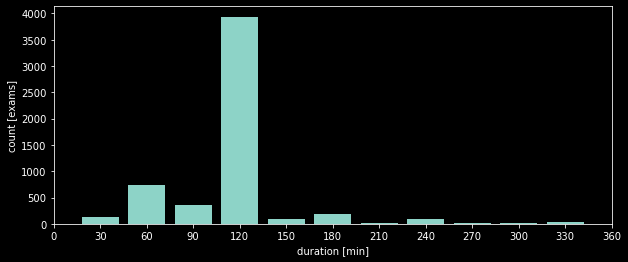

In [48]:
duration_counts = edates['duration']\
    .value_counts()\
    .reset_index()\
    .rename(columns={'duration':'count', 'index':'duration'})\
    .sort_values(by='duration', ascending=False)

fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(edates['duration'], bins=range(30, 361, 30), rwidth=0.8, align='left')
ax.set_xticks(range(0, 361, 30))
ax.set_ylabel('count [exams]')
ax.set_xlabel('duration [min]');

### Visualize timeline of exam-active students

In [49]:
exam_counts = edates[['date', 'exam_id']]\
    .drop_duplicates()\
    .groupby('date')\
    .count()\
    .reset_index()\
    .rename(columns={'exam_id':'exam_count'})\
    .sort_values(by='date')

In [50]:
exam_active_students_counts = estudents[['date', 'student_id']]\
    .drop_duplicates()\
    .groupby('date')\
    .count()\
    .reset_index()\
    .rename(columns={'student_id':'student_count'})\
    .sort_values(by='date')

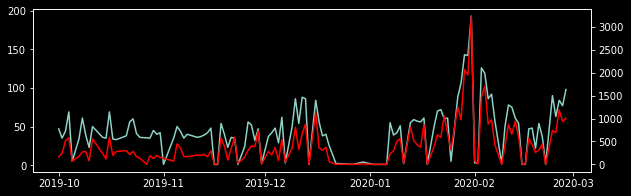

In [51]:
fig, ax = plt.subplots(figsize=(10, 3))
ax2 = ax.twinx()
ax.plot(exam_counts['date'], exam_counts['exam_count'])
ax2.plot(exam_active_students_counts['date'], 
        exam_active_students_counts['student_count'], color='r')

## Save the processed data

In [53]:
processed_dst = '../data/processed'
students.to_csv(join(processed_dst, 'students_processed.csv'), index=False)
lecturers.to_csv(join(processed_dst, 'lecturers_processed.csv'), index=False)
lectures.to_csv(join(processed_dst, 'lectures_processed.csv'), index=False)
studies.to_csv(join(processed_dst, 'studies_processed.csv'), index=False)
organisations.to_csv(join(processed_dst, 'organisations_processed.csv'), index=False)
groups.to_csv(join(processed_dst, 'groups_processed.csv'), index=False)
dates.to_csv(join(processed_dst, 'dates_processed.csv'), index=False)
rooms.to_csv(join(processed_dst, 'rooms_processed.csv'), index=False)
estudents.to_csv(join(processed_dst, 'exam_students_processed.csv'), index=False)
electurers.to_csv(join(processed_dst, 'exam_lecturers_processed'), index=False)
exams.to_csv(join(processed_dst, 'exams.csv'), index=False)
edates.to_csv(join(processed_dst, 'exam_dates.csv'), index=False)

In [58]:
sample_dst = "../data/raw/datensamples"
students[0:10].to_csv(join(sample_dst, "students.csv"))
lecturers[0:10].to_csv(join(sample_dst, "lecturers.csv"))
lectures[0:10].to_csv(join(sample_dst, "lectures.csv"))
studies[0:10].to_csv(join(sample_dst, "studies.csv"))
organisations[0:10].to_csv(join(sample_dst, "organisations.csv"))
groups[0:10].to_csv(join(sample_dst, "groups.csv")) # no persons
dates[0:10].to_csv(join(sample_dst, "dates.csv")) # no persons
rooms[0:10].to_csv(join(sample_dst, "rooms.csv")) # no persons
estudents[0:10].to_csv(join(sample_dst, "exam_students.csv"))
electurers[0:10].to_csv(join(sample_dst, "exam_lecturers.csv"))
exams[0:10].to_csv(join(sample_dst, "exams.csv")) # no persons
edates[0:10].to_csv(join(sample_dst, "exam_dates.csv"))